In [ ]:
import os
import scanpy as sc
import pandas as pd
import numpy as np

import deconv as dv

In [69]:
datadir = os.path.join("..", "data", "pbmc")

In [70]:
%%bash
cd ../data/pbmc
ls

bulk.txt
raw
reference.h5ad
subtype_proportions.txt
true.csv


In [71]:
%%bash
rm -rf "../data/pbmc/raw"
mkdir -p "../data/pbmc/raw"
cd "../data/pbmc/raw"
wget "http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz"
tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz

--2025-02-23 13:55:49--  http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 2606:4700::6812:ad, 2606:4700::6812:1ad, 104.18.1.173, ...
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|2606:4700::6812:ad|:80... connected.


HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz [following]
--2025-02-23 13:55:49--  https://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|2606:4700::6812:ad|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7621991 (7.3M) [application/x-tar]
Saving to: ‘pbmc3k_filtered_gene_bc_matrices.tar.gz’

     0K .......... .......... .......... .......... ..........  0% 66.9M 0s
    50K .......... .......... .......... .......... ..........  1% 4.51M 1s
   100K .......... .......... .......... .......... ..........  2%  190M 1s
   150K .......... .......... .......... .......... ..........  2% 6.68M 1s
   200K .......... .......... .......... .......... ..........  3%  249M 1s
   250K .......... .......... .......... .......... ..........  4% 15.0M 1s
   30

In [72]:
# Single-cell reference PBMC_3k: http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz
adata = sc.read_10x_mtx(
    os.path.join(datadir, "raw/filtered_gene_bc_matrices/hg19"),
    var_names="gene_symbols",
)
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
adata.var = adata.var.reset_index().set_index("gene_ids").rename(columns={"index": "symbol"})
adata

AnnData object with n_obs × n_vars = 2700 × 13714
    obs: 'n_genes'
    var: 'symbol', 'n_cells'

In [73]:
# Bulk proportions extracted from Table S6: https://doi.org/10.1016/j.celrep.2019.01.041
proportions = pd.read_table(os.path.join(datadir, "subtype_proportions.txt"), index_col=0)
mapping = {
    'Progenitors':None,
    'B Naive':"B cells",
    'B NSM':"B cells",
    'B SM':"B cells",
    'B Ex':"B cells",
    'Plasmablasts':"B cells",
    'T CD4 Naive':"CD4 T",
    'Tregs':"CD4 T",
    'Tfh':"CD4 T",
    'Th1':"CD4 T",
    'Th1/Th17':"CD4 T",
    'Th17':"CD4 T",
    'Th2':"CD4 T",
    'T CD4 TE':"CD4 T",
    'T CD8 Naive':"CD8 T",
    'T CD8 CM':"CD8 T",
    'T CD8 EM':"CD8 T",
    'T CD8 TE':"CD8 T",
    'T gd Vd2':None,
    'T gd non-Vd2':None,
    'MAIT':None,
    'NK':"NK",
    'pDCs':"DCs",
    'mDCs':"DCs",
    'Monocytes C':"Monocytes",
    'Monocytes I':"Monocytes",
    'Monocytes NC':"Monocytes",
    'Neutrophils LD':None,
    'Basophils LD':None,
}

props = dict([(k,[]) for k in mapping.values() if k is not None])
props["sample"] = []
for row in proportions.iterrows():
    temp = dict()
    props["sample"].append(row[0])
    for k,v in mapping.items():

        if v is not None:
            if v not in temp.keys():
                temp[v] = 0

            temp[v] += row[1][k]

    for k,v in temp.items():
        props[k].append(v)
    
proportions = pd.DataFrame(props).set_index("sample")
proportions = proportions.div(proportions.sum(1), axis=0)
proportions.index += "_PBMC"
proportions.to_csv(os.path.join(datadir, "true.csv"))
proportions

,B cells,CD4 T,CD8 T,NK,DCs,Monocytes
sample,,,,,,
453W_PBMC,0.058854,0.287304,0.320502,0.076899,0.010775,0.245667
684C_PBMC,0.114487,0.341211,0.177874,0.097033,0.014584,0.254811
CR3L_PBMC,0.137329,0.330611,0.186336,0.133018,0.016135,0.196571
FLWA_PBMC,0.102362,0.289034,0.102056,0.238477,0.012963,0.255109
FY2H_PBMC,0.087813,0.239368,0.215721,0.032445,0.016971,0.407682
CYFZ_PBMC,0.098471,0.204259,0.327271,0.164706,0.007765,0.197529
925L_PBMC,0.187059,0.231691,0.223318,0.115577,0.007860,0.234494
9JD4_PBMC,0.094967,0.343631,0.269980,0.086157,0.010984,0.194281
G4YW_PBMC,0.087500,0.284971,0.156894,0.204167,0.009567,0.256901


In [74]:
%%bash
cd "../data/pbmc/raw"
rm -rf "bulk"
mkdir -p "bulk"
cd "bulk"
wget -O "GSE107011_Processed_data_TPM.txt.gz" "https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE107011&format=file&file=GSE107011%5FProcessed%5Fdata%5FTPM%2Etxt%2Egz"

--2025-02-23 13:55:50--  https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE107011&format=file&file=GSE107011%5FProcessed%5Fdata%5FTPM%2Etxt%2Egz
Resolving www.ncbi.nlm.nih.gov (www.ncbi.nlm.nih.gov)... 130.14.29.110
Connecting to www.ncbi.nlm.nih.gov (www.ncbi.nlm.nih.gov)|130.14.29.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15420393 (15M) [application/octet-stream]
Saving to: ‘GSE107011_Processed_data_TPM.txt.gz’

     0K .......... .......... .......... .......... ..........  0%  238K 63s
    50K .......... .......... .......... .......... ..........  0%  475K 47s
   100K .......... .......... .......... .......... ..........  0% 4.27M 32s
   150K .......... .......... .......... .......... ..........  1%  531K 31s
   200K .......... .......... .......... .......... ..........  1% 16.1M 25s
   250K .......... .......... .......... .......... ..........  1% 6.57M 21s
   300K .......... .......... .......... .......... ..........  2%  520K 22s
   350K

In [75]:
# Bulk from S13 cohort: GSE107011_Processed_data_TPM.txt.gz
bulk = pd.read_table(os.path.join(datadir, "raw/bulk/GSE107011_Processed_data_TPM.txt.gz"), index_col=0)
bulk = bulk[proportions.index]
bulk.index = bulk.index.str.split(".").str[0]
bulk.drop_duplicates(keep=False, inplace=True)
bulk.to_csv(os.path.join(datadir, "bulk.txt"), sep="\t")
bulk

,453W_PBMC,684C_PBMC,CR3L_PBMC,FLWA_PBMC,FY2H_PBMC,CYFZ_PBMC,925L_PBMC,9JD4_PBMC,G4YW_PBMC,4DUY_PBMC,CZJE_PBMC,36TS_PBMC
ENSG00000223972,2.019260,1.05433,1.628920,1.864710,2.547560,3.011490,3.831050,7.432370,3.871090,5.862480,2.651110,6.943370
ENSG00000227232,3.835990,2.34941,3.020950,2.788540,4.852060,2.621530,3.216870,0.343774,0.783651,0.000000,2.782310,0.589092
ENSG00000237613,3.599090,7.34964,3.351750,3.446380,3.349200,3.092800,1.231590,1.980980,1.540490,0.398058,2.799720,0.906652
ENSG00000238009,0.354797,1.84346,0.966647,1.592777,2.352404,1.286230,1.581160,1.547670,0.920256,0.964836,1.525297,0.755531
ENSG00000239945,2.221700,2.57290,1.887030,0.043438,0.349257,0.487118,1.518550,0.000000,1.949500,2.276820,0.393505,1.022700
...,...,...,...,...,...,...,...,...,...,...,...,...
ERCC-00163,0.274628,0.00000,0.000000,2.159600,0.549218,0.000000,0.000000,0.000000,0.255892,0.000000,0.000000,0.000000
ERCC-00165,6.071060,0.00000,1.825820,2.124800,0.945928,0.420407,1.812370,0.613574,1.889930,0.000000,5.624410,6.567020
ERCC-00168,0.000000,0.00000,0.000000,0.000000,0.109384,0.000000,0.000000,0.099316,0.000000,0.000000,0.379696,0.104198
ERCC-00170,0.655829,0.76428,0.590850,1.937310,0.766653,0.000000,0.564767,0.000000,0.000000,0.417021,3.231460,2.608230


In [76]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
adata = adata[adata.obs.n_genes_by_counts < 2500, :].copy()
adata = adata[adata.obs.pct_counts_mt < 5, :].copy()
adata

AnnData object with n_obs × n_vars = 2695 × 13714
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'symbol', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [77]:
dv.tl.scale_log_center(adata)

In [78]:
sc.tl.pca(adata, svd_solver='arpack', random_state=0)
sc.pp.neighbors(adata, n_neighbors=10, random_state=0)
sc.tl.leiden(adata, resolution=0.8, random_state=0)

In [79]:
sc.tl.umap(adata, min_dist=0.5, spread=3.0, random_state=0)

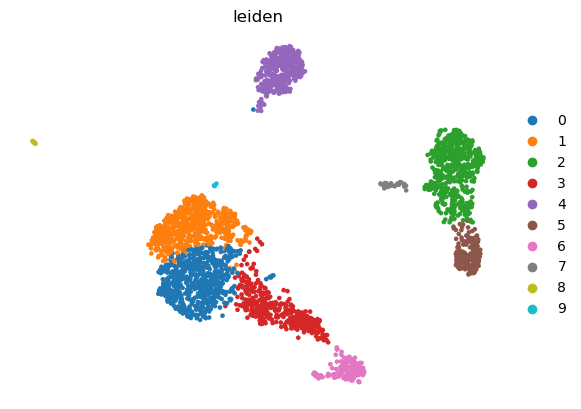

In [80]:
sc.pl.umap(adata, color=['leiden'], ncols=2, frameon=False)

In [81]:
adata.obs["labels"] = adata.obs["leiden"].map({"0":"CD4 T", "1":"CD4 T", "2":"Monocytes", "3":"B cells", "4":"NK", "5":"CD8 T", "6":"Monocytes", "7":"DCs", "8":"platelet"}).astype("category")

In [82]:
adata = adata[adata.obs["labels"] != "platelet", :].copy()

In [83]:
adata.obs.groupby("labels").size()

/tmp/ipykernel_51007/242020526.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata.obs.groupby("labels").size()


labels
B cells       362
CD4 T        1126
CD8 T         160
DCs            33
Monocytes     648
NK            351
dtype: int64

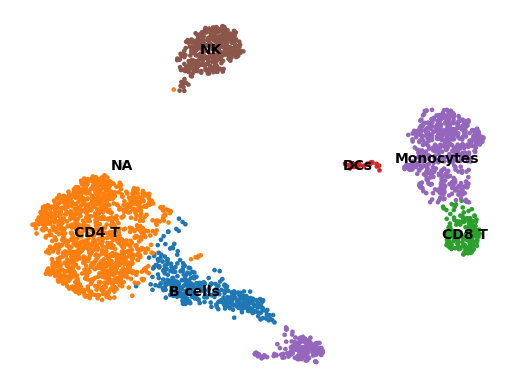

In [84]:
sc.pl.umap(adata, color='labels', legend_loc='on data', title='', frameon=False)

In [85]:
adata.X = adata.layers["counts"]
adata.var.drop(columns=['n_cells', 'mt', 'n_cells_by_counts', 'mean_counts',
       'pct_dropout_by_counts', 'total_counts'], inplace=True)
adata.obs.drop(columns=['n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt',
       'pct_counts_mt'], inplace=True)
del adata.layers
del adata.uns
del adata.obsm
del adata.varm
del adata.obsp

In [86]:
adata.write_h5ad(os.path.join(datadir, "reference.h5ad"))